# First try on interfacing EnergyPlus and REHO

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eppy.modeleditor import IDF
import seaborn as sns
import html5lib

import reho.plotting.yearly_profile_builder
from reho.model.reho import *
from reho.plotting.plotting import temperature_profile

## Hardcoded "optimization" loop

The goal is to simulate the CELLS building using EnergyPlus. From this simulation, variable of interests will be extracted to run a REHO optimization. From this optimization, installed capacity of technologies will be extracted from the results. Finally, those results will be reused as input into the EnergyPlus simulation. Convergence of the variable of interest will then be studied.

### First `buildings.csv` generation

The minimum variables needed by `REHO` in its buildings.csv files are the following:
- `area_era_m2`
- `id_building` --> set as 1
- `temperature_cooling_supply_C` --> kept as default 12°
- `temperature_cooling_return_C` --> kept as default 17°
- `temperature_heating_supply_C` --> kept as default 65°
- `temperature_heating_return_C` --> kept as default 50°
- `area_facade_m2` 
- `area_roof_solar_m2` --> 100% of roof availability
- `temperature_interior_C` -->  extracted from `.idf` temperature setpoint
- `ratio` --> kept as default 1
- `status` --> kept as default [existing]
- `id_class` --> set from SIA norms individual office:  type III  
- `solar_gain_factor_signature_m2` --> set to default values 0.07
- `thermal_specific_capacity_Wh_m2_K`
- `thermal_transmittance_signature_kW_m2_K` --> extracted from EPlus results

In [2]:
# hardcoded base values for the buildings.csv file
data = {
    'area_era_m2': [53.91],
    'id_building': [1],
    'temperature_cooling_supply_C': [12],
    'temperature_cooling_return_C': [17],
    'temperature_heating_supply_C': [65],
    'temperature_heating_return_C': [50],
    'area_facade_m2': [72.07],
    'area_roof_solar_m2': [53.91],
    'temperature_interior_C': [21],
    'ratio': [1.0],
    'status': ['[existing]'],
    'id_class': ['III'],
    'solar_gain_factor_signature_m2': [0.07],  # not computed yet
    'thermal_specific_capacity_Wh_m2_K': [120],
    'thermal_transmittance_signature_kW_m2_K': [0.169/1000]
}

buildings = pd.DataFrame(data)
display(buildings)

,area_era_m2,id_building,temperature_cooling_supply_C,temperature_cooling_return_C,temperature_heating_supply_C,temperature_heating_return_C,area_facade_m2,area_roof_solar_m2,temperature_interior_C,ratio,status,id_class,solar_gain_factor_signature_m2,thermal_specific_capacity_Wh_m2_K,thermal_transmittance_signature_kW_m2_K
0,53.91,1,12,17,65,50,72.07,53.91,21,1.0,[existing],III,0.07,120,0.000169


In [3]:
## Define the paths to the various inputs
# Specify path to the IDF file
idf_file_path = r".\input_data\CELLS.idf"

# Specify path to the IDD file
idd_file_path = r".\input_data\Energy+.idd" # Energy+ v9.4 IDD

# Specify path to the weather file
weather_file_path = r".\input_data\-_FRIBOURG_MN7.epw"

# Set the idd file
IDF.setiddname(idd_file_path)

# Create an IDF object and load the IDF file
idf = IDF(idf_file_path, weather_file_path)

# Specify path to the EnergyPlus results folder
idf_results_path = r".\output_data"

In [4]:
## Run base EnergyPlus simulation
# readvars = True creates a .cvs of the results
# annual = True forces the simulation to run on an annual basis

idf.run(readvars=True,output_directory=idf_results_path, annual=True, verbose='q', output_prefix='idf1_')

## Helper functions

In [5]:
# Steven Firth datetime parser
def parse_energyplus_datetime_string(st, year=2021):
    st=st.strip()
    month=int(st[0:2])
    day=int(st[3:5])
    hour=int(st[7:9])
    minute=int(st[10:12])
    second=(st[13:15])
    if not hour==24:
        dt=pd.Timestamp(year,month,day,hour,minute)
    else:
        hour=0
        dt=pd.Timestamp(year,month,day,hour,minute)
        dt+=pd.Timedelta('1 day')
    return dt

def extract_U_factor(results_path=r'output_data\idf1_tbl.htm'):
    # read EPlus results as html
    df = pd.read_html(results_path, header=0)
    # detect indices where "U-Factor" appears
    indices = []
    numerator = 0
    denominator = 0
    for idx, tables in enumerate(df):
        # Check if "U-factor" appears in the column names
        if any(isinstance(col, str) and 'U-Factor' in col for col in tables.columns):
            # If found, save the table index
            indices.append(idx)
    # extract summary table related to CELLS walls 
    
    # !!! Hardcoded        
    df_ufactor = pd.DataFrame(df[32])
    
    # recompute averaged U-factor    
    numerator = numerator + ((df_ufactor['U-Factor with Film [W/m2-K]']*df_ufactor['Gross Area [m2]']).sum())
    denominator = denominator + df_ufactor['Gross Area [m2]'].sum()
    U_factor = numerator/denominator
    # convert to W -> kW
    return U_factor/1000, indices

def modify_setpoint(idf, new_setpoint, name_SIA, modified_hours=list(range(9, 18)), verbose = 'q'):
    for entity  in idf.idfobjects:
        for field in idf.idfobjects[entity]:
            if 'Name' in field.objls: # check field with names only
                if name_SIA in field.Name: #modify fields where modified SIA file appears
                    for hours in modified_hours:
                        #if hours in modified_hours:
                        # Replace the value with new setpoint
                            setattr(field, f"Value_{hours}", new_setpoint)
                    if verbose != 'q':
                        print(field)
                        
def modify_capacity(new_capacity):
    print(new_capacity)

In [6]:
U_Factor, _ = extract_U_factor(r'output_data\idf1_tbl.htm')

In [7]:
SIA_heating_schedule = '10003_-50_12_21'
SIA_cooling_schedule = '10003_100_28_26'

In [8]:
buildings['thermal_transmittance_signature_kW_m2_K'] = U_Factor

Key egid not in the dictionary
Key class not in the dictionary
Key period not in the dictionary
Key capita_cap not in the dictionary
Key height_m not in the dictionary
Key count_floor not in the dictionary
Key source_heating not in the dictionary
Key source_hotwater not in the dictionary
Key x not in the dictionary
Key y not in the dictionary
Key z not in the dictionary
Key geometry not in the dictionary
Key transformer not in the dictionary
Key energy_heating_signature_kWh_y not in the dictionary
Key energy_cooling_signature_kWh_y not in the dictionary
Key energy_hotwater_signature_kWh_y not in the dictionary
Key energy_el_kWh_y not in the dictionary
Key roof_annual_irr_kWh_y not in the dictionary
Key facade_annual_irr_kWh_y not in the dictionary
No geometry in the dataframe
Gurobi 11.0.0:   tech:nodefilestart = 0.5
Gurobi 11.0.0: optimal solution; objective 2358.475227
2843 simplex iteration(s)
1 branching node(s)
absmipgap=0.120509, relmipgap=5.1096e-05
              Costs_op   Cost

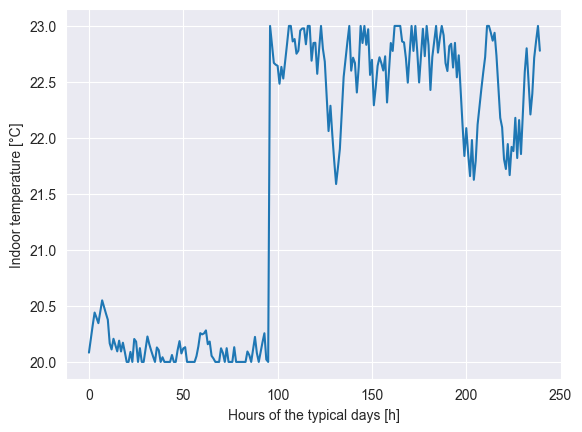

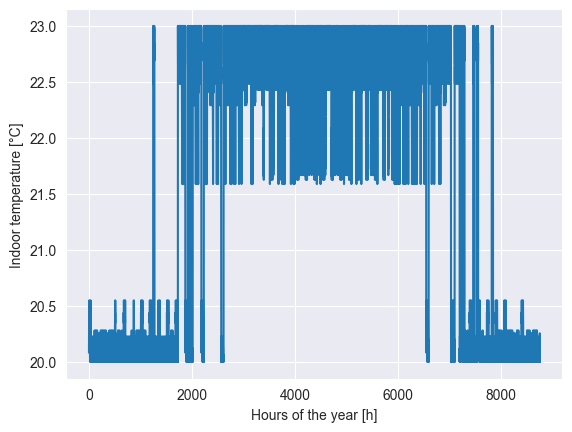

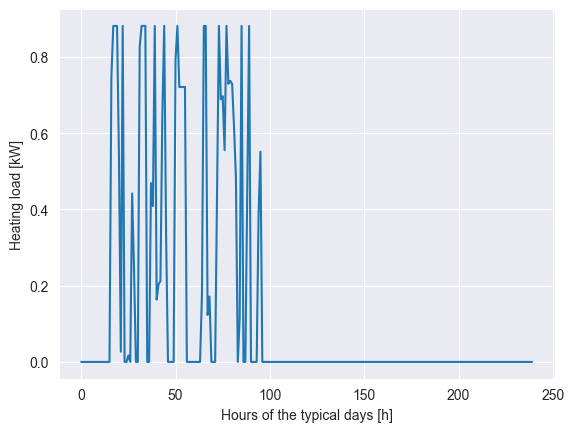

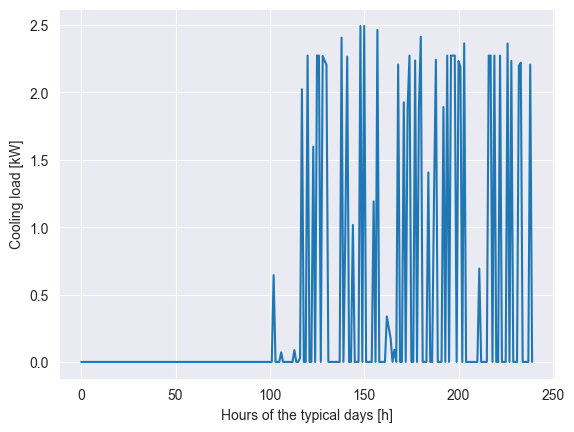

Results are saved in results/reho.pickle
Results are saved in results/reho_totex.xlsx


In [61]:
# Set building parameters
# you can as well define your district from a csv file instead of reading the database
reader = QBuildingsReader()
qbuildings_data = reader.read_csv(buildings_filename=r'.\data\buildings.csv', nb_buildings=1)

# Select weather data
cluster = {'Location': 'Geneva', 'Attributes': ['I', 'T', 'W'], 'Periods': 10, 'PeriodDuration': 24}

# Set scenario
scenario = dict()
scenario['Objective'] = 'TOTEX'
scenario['name'] = 'totex'
scenario['exclude_units'] = ['Battery', 'NG_Cogeneration', 'PV']
scenario['enforce_units'] = []

# Initialize available units and grids
grids = infrastructure.initialize_grids()
units = infrastructure.initialize_units(scenario, grids)

# Set method options
method = {'building_scale' : True}

# Run optimization
reho_model = reho(qbuildings_data=qbuildings_data, units=units, grids=grids, cluster=cluster, scenario=scenario, method=method, solver="gurobi")

n_house = len(qbuildings_data["buildings_data"])

reho_model.parameters["HeatGains"] = np.random.randint(low=0, high=2, size=242 * n_house) # 242 means 10 typical days of 24 hours and 2 extreme hours, kW
reho_model.parameters["SolarGains"] = np.random.randint(low=0, high=2, size=242 * n_house)  # there is one profile per house, kW
reho_model.parameters["Domestic_electricity"] = np.random.randint(low=0, high=2, size=242 * n_house)
reho_model.parameters["Cooling"] = np.array([1.0] * n_house)
reho_model.parameters["T_comfort_min_0"] = np.array([20.0] * n_house)
reho_model.parameters["T_comfort_max_0"] = np.array([23.0] * n_house)

reho_model.single_optimization()

print("\n Space heating MWh/yr: \n", reho_model.results["totex"][0]["df_Annuals"].xs("SH")[0:2]["Demand_MWh"])
print("\n Cooling MWh/yr: \n", reho_model.results["totex"][0]["df_Annuals"].xs("Cooling"))
print("\n Solar Gains MWh/yr: \n", reho_model.results["totex"][0]["df_Annuals"].xs("SolarGains")["Supply_MWh"])
print("\n Internal Heat Gains MWh/yr: \n", reho_model.results["totex"][0]["df_Annuals"].xs("HeatGains")["Supply_MWh"])
print("\n Domestic Electricity MWh/yr: \n", reho_model.results["totex"][0]["df_Annuals"].xs("Electricity")[4:6]["Demand_MWh"])

plt.plot(reho_model.results["totex"][0]["df_Buildings_t"]["T_in"].xs("Building1").values[0:-2])
plt.xlabel("Hours of the typical days [h]")
plt.ylabel("Indoor temperature [°C]")
plt.show()

# Extract profiles from REHO
reho_T_in, reho_timeserie = temperature_profile(reho_model.results["totex"][0])
reho_Q_heating = reho_model.results["totex"][0]["df_Buildings_t"]["House_Q_heating"].xs("Building1").values[0:-2]
reho_Q_cooling = reho_model.results["totex"][0]["df_Buildings_t"]["House_Q_cooling"].xs("Building1").values[0:-2]


# Plot them using a loop

plt.plot(reho_T_in)
plt.xlabel("Hours of the year [h]")
plt.ylabel("Indoor temperature [°C]")
plt.show()

plt.plot(reho_Q_heating)
plt.xlabel("Hours of the typical days [h]")
plt.ylabel("Heating load [kW]")
plt.show()

plt.plot(reho_Q_cooling)
plt.xlabel("Hours of the typical days [h]")
plt.ylabel("Cooling load [kW]")
plt.show()

#Save results
reho_model.save_results(format=['xlsx', 'pickle'], filename='reho')

In [10]:
display(reho_model.results.items())

dict_items([('totex', {0: {'df_Performance':               Costs_op   Costs_inv  ANN_factor  Costs_grid_connection  \
Hub                                                                     
Building1 -2481.171128  1580.49905    0.061157                    0.0   
Network   -2481.171128  1580.49905    0.061157                    0.0   

           Costs_rep  Costs_ft      GWP_op  GWP_constr  EMOO_CAPEX  EMOO_OPEX  \
Hub                                                                             
Building1        0.0         0 -2160.56801  440.851972         NaN        NaN   
Network          0.0         0 -2160.56801  440.851972         0.0        0.0   

           EMOO_TOTEX  EMOO_GWP  EMOO_grid   Objective  
Hub                                                     
Building1         NaN       NaN        NaN         NaN  
Network           0.0       0.0        0.0 -900.673481  , 'df_Annuals':                                             Demand_MWh  Supply_MWh
Layer       Hub            

In [11]:
new_capacity = reho_model.results['totex'][0]['df_Unit']['Units_Mult'].sum()

In [12]:
# generate updated idf object 
modify_capacity(new_capacity)

13.19315894766


In [13]:
# # main loop
# new_capacity = 'autosize'
# for i in range(0,10):
#     ### EnergyPlus Simulation
#     #update idf object with new idf_file_path
#     idf.idfobjects['Sizing:System'][0]['Cooling_Design_Capacity'] = new_capacity
#     idf = IDF(idf_file_path, weather_file_path)
#     
#     # generate new EPlus results
#     idf.run(readvars=True,output_directory=idf_results_path, annual=True, verbose='q', output_prefix='idf1_')
#     
#     ### EnergyPlus - REHO interface
#     # extract U-Factor from EPlus results
#     U_Factor, _ = extract_U_factor(r'output_data\idf1_tbl.htm')
#     display(U_Factor)
#     # new_thermal_capacity = extract_thermal_capacity()
#     new_heat_capacity = 100
#     
#     # Update REHO object   
#     reho_model.buildings_data['Building1']['U_h'] = U_Factor
#     reho_model.buildings_data['Building1']['Heat_capacity'] = new_heat_capacity*1000 # from kW to W 
# 
#     ### REHO optimization
#     # Run REHO optimization
#     reho_model.single_optimization()
#     
#     # Extract the installed capacity
#     new_capacity = reho_model.results['totex'][0]['df_Unit']['Units_Mult'].sum()

In [14]:
idf.idfobjects['Sizing:System'][0].objls

['key',
 'AirLoop_Name',
 'Type_of_Load_to_Size_On',
 'Design_Outdoor_Air_Flow_Rate',
 'Central_Heating_Maximum_System_Air_Flow_Ratio',
 'Preheat_Design_Temperature',
 'Preheat_Design_Humidity_Ratio',
 'Precool_Design_Temperature',
 'Precool_Design_Humidity_Ratio',
 'Central_Cooling_Design_Supply_Air_Temperature',
 'Central_Heating_Design_Supply_Air_Temperature',
 'Type_of_Zone_Sum_to_Use',
 '100_Outdoor_Air_in_Cooling',
 '100_Outdoor_Air_in_Heating',
 'Central_Cooling_Design_Supply_Air_Humidity_Ratio',
 'Central_Heating_Design_Supply_Air_Humidity_Ratio',
 'Cooling_Supply_Air_Flow_Rate_Method',
 'Cooling_Supply_Air_Flow_Rate',
 'Cooling_Supply_Air_Flow_Rate_Per_Floor_Area',
 'Cooling_Fraction_of_Autosized_Cooling_Supply_Air_Flow_Rate',
 'Cooling_Supply_Air_Flow_Rate_Per_Unit_Cooling_Capacity',
 'Heating_Supply_Air_Flow_Rate_Method',
 'Heating_Supply_Air_Flow_Rate',
 'Heating_Supply_Air_Flow_Rate_Per_Floor_Area',
 'Heating_Fraction_of_Autosized_Heating_Supply_Air_Flow_Rate',
 'Heating_F

In [15]:
reho_model.results

{'totex': {0: {'df_Performance':               Costs_op   Costs_inv  ANN_factor  Costs_grid_connection  \
   Hub                                                                     
   Building1 -2481.171128  1580.49905    0.061157                    0.0   
   Network   -2481.171128  1580.49905    0.061157                    0.0   
   
              Costs_rep  Costs_ft      GWP_op  GWP_constr  EMOO_CAPEX  EMOO_OPEX  \
   Hub                                                                             
   Building1        0.0         0 -2160.56801  440.851972         NaN        NaN   
   Network          0.0         0 -2160.56801  440.851972         0.0        0.0   
   
              EMOO_TOTEX  EMOO_GWP  EMOO_grid   Objective  
   Hub                                                     
   Building1         NaN       NaN        NaN         NaN  
   Network           0.0       0.0        0.0 -900.673481  ,
   'df_Annuals':                                             Demand_MWh  Supply_M

## EnergyPlus profile exploration

The goal here is to reconstruct relevant KPI from EnergyPlus simulation results to be able to compare them with REHO results. The selected KPIs are:

- SPH
- Electricity rate (heating and cooling)
- Equipment capacity (found in df_Units in REHO results)
- $T_{int}$ profile

From EnergyPlus, we also want to extract internal and solar gains.

In [16]:
# load idf1_out.csv
df=pd.read_csv(r".\output_data\idf1_out.csv", 
               parse_dates=[0],
               index_col=[0],
               date_parser=parse_energyplus_datetime_string 
              )

# Create filters
operative_temperature = [col for col in df.columns if 'Operative' in col]
latent_gains = [col for col in df.columns if 'Latent' in col]
windows_solar_gains = [col for col in df.columns if 'Windows Total Transmitted Solar' in col]

# for column in df.columns:
#     if 'Operative' in column:
#         operative_temperature.append(column)  
#     if 'Latent' in column:
#         latent_gains.append(column)
#     if 'Windows Total Transmitted Solar' in column:
#         print(column)
#         windows_solar_gains.append(column)


In [67]:
reho_T_in.shape

(8760, 1)

<Axes: xlabel='Date/Time'>

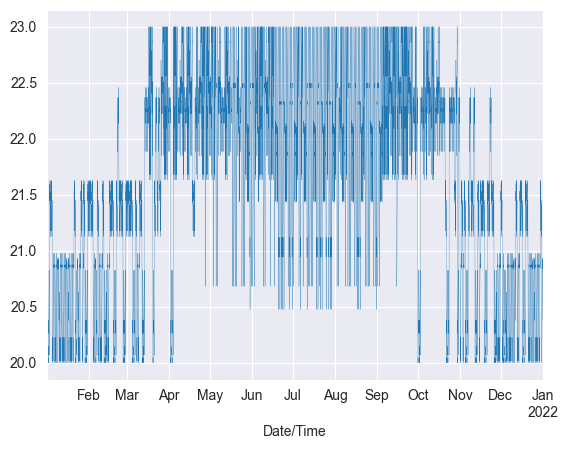

In [45]:
df_reho = pd.DataFrame(reho_T_in,df.index, columns=['REHO T_in'])
df_reho['REHO T_in'].plot(kind='line',lw= 0.20)

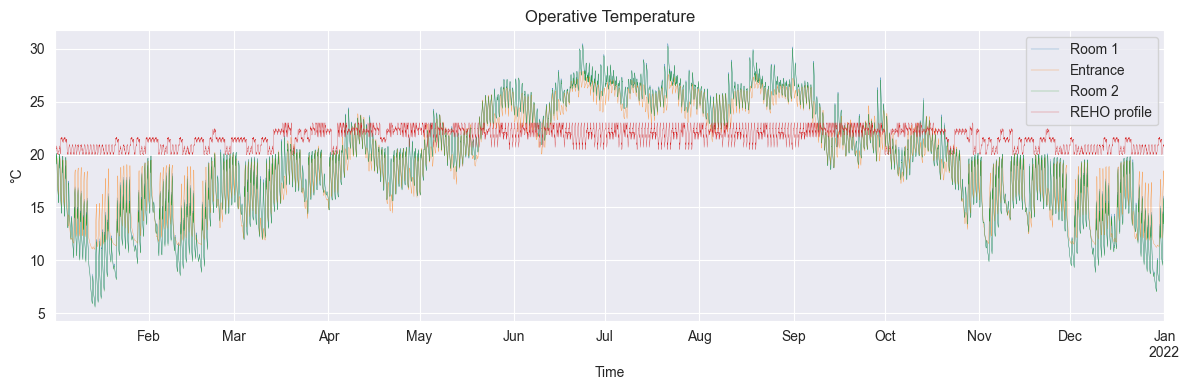

In [44]:
df[operative_temperature].plot(kind='line', lw= 0.20, figsize=(12, 4))
df_reho['REHO T_in'].plot(kind='line',lw= 0.20)
plt.legend(["Room 1","Entrance", "Room 2", "REHO profile"])
plt.title('Operative Temperature')
plt.xlabel('Time')
plt.ylabel('°C')
plt.tight_layout()
plt.show()

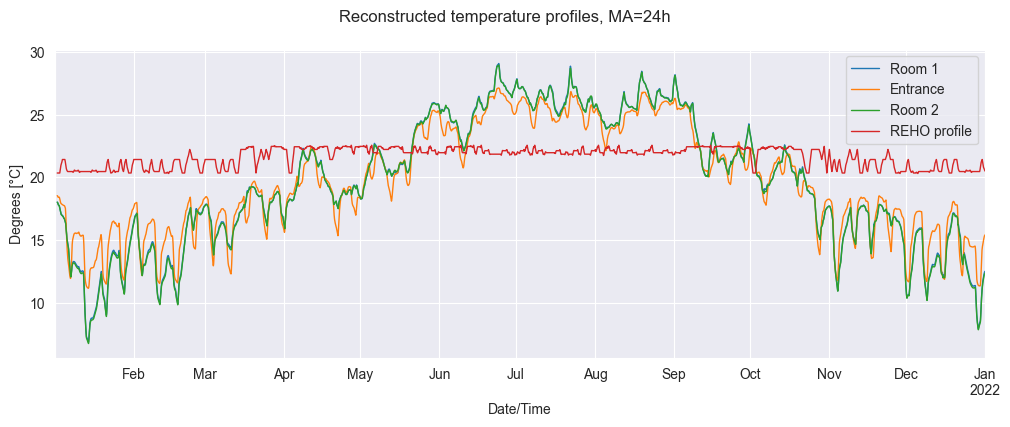

In [59]:
df[operative_temperature].rolling(window=24).mean().plot(kind='line', lw= 1, figsize=(12, 4))
df_reho['REHO T_in'].rolling(window=24).mean().plot(kind='line',lw= 1)
plt.legend(["Room 1","Entrance", "Room 2", "REHO profile"])
plt.ylabel('Degrees [°C]')
plt.suptitle('Reconstructed temperature profiles, MA=24h')
plt.show()

In [18]:
df['Total Internal Latent Gain Energy [J](hourly)'] = df[latent_gains].sum(axis=1)

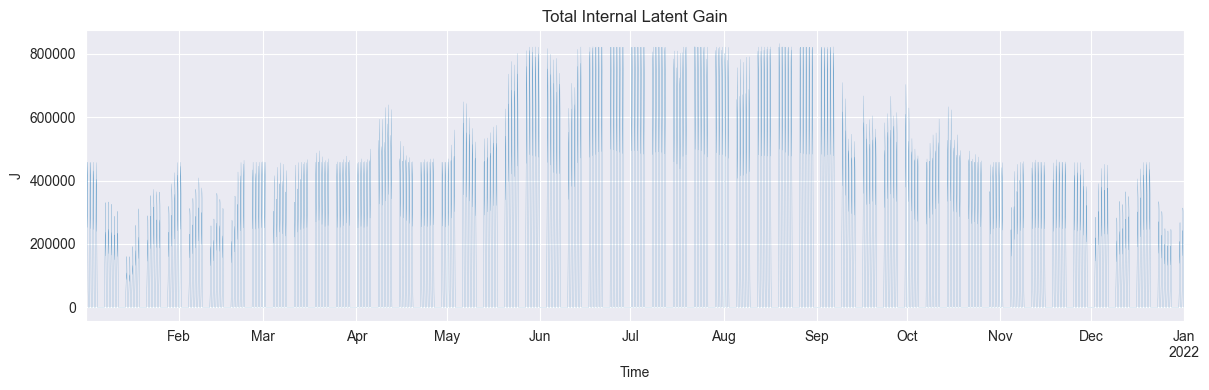

In [19]:
df['Total Internal Latent Gain Energy [J](hourly)'].plot(kind='line', lw=0.1, figsize=(12, 4))
plt.title('Total Internal Latent Gain')
plt.tight_layout()
plt.xlabel('Time')
plt.ylabel('J')
plt.show()


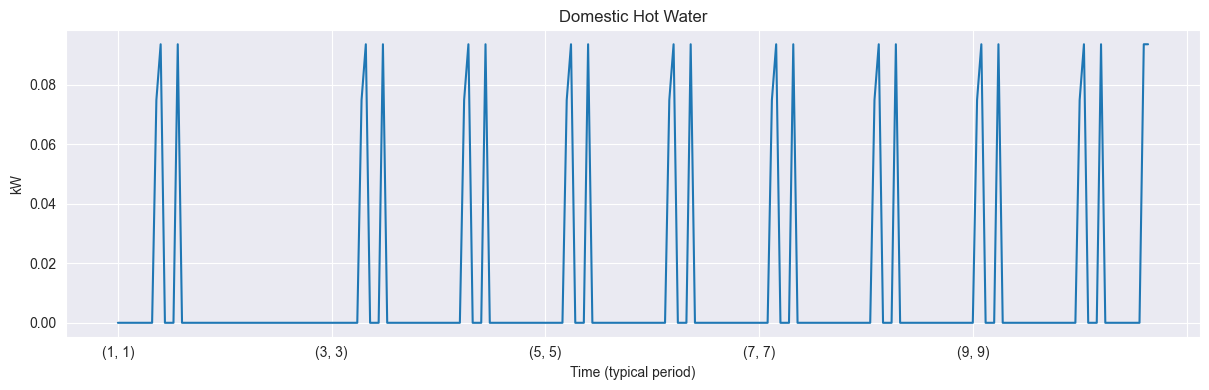

In [20]:
reho_model.results['totex'][0]['df_Buildings_t']['House_Q_DHW'].xs('Building1').plot(kind='line', figsize=(12, 4))

plt.title('Domestic Hot Water')
plt.tight_layout()
plt.xlabel('Time (typical period)')
plt.ylabel('kW')
plt.show()

In [21]:
# merge DHW per period on period per year
DHW = reho_model.results['totex'][0]['df_Buildings_t']['House_Q_DHW'].xs('Building1')
time_index =reho_model.results['totex'][0]['df_Index']['PeriodOfYear']

In [22]:
time_index.groupby(time_index).count()

PeriodOfYear
1      864
2     1272
3     1056
4      264
5      984
6     1320
7      720
8     1080
9      672
10     528
Name: PeriodOfYear, dtype: int64

In [23]:
DHW.groupby('Period').sum()

Period
1     0.261828
2     0.000000
3     0.261828
4     0.261828
5     0.261828
6     0.261828
7     0.261828
8     0.261828
9     0.261828
10    0.261828
11    0.093510
12    0.093510
Name: House_Q_DHW, dtype: float64

In [24]:
# Create a new df_reho with the same index as df
df_reho = pd.DataFrame(index=df.index)
# copy filtered columns in df_reho
df_reho['Latent Gains'] = df[latent_gains].sum(axis=1)
df_reho['Solar Gains'] = df[windows_solar_gains].sum(axis=1)

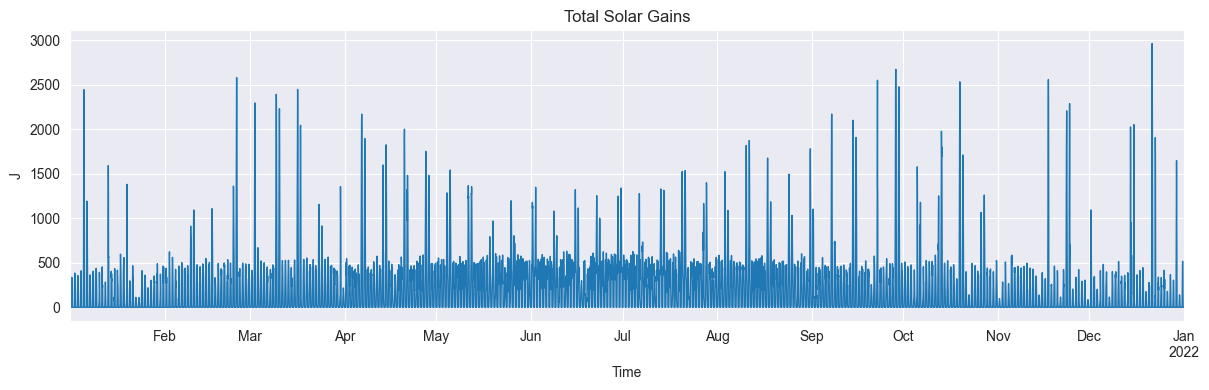

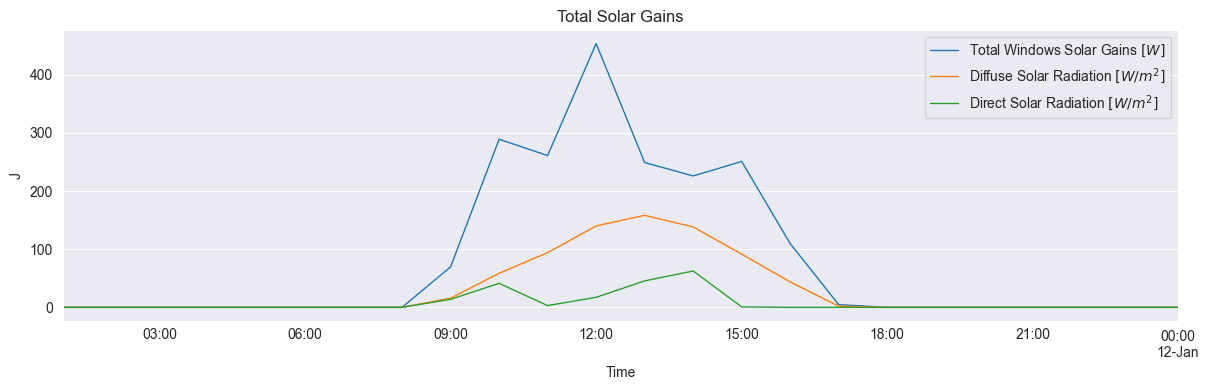

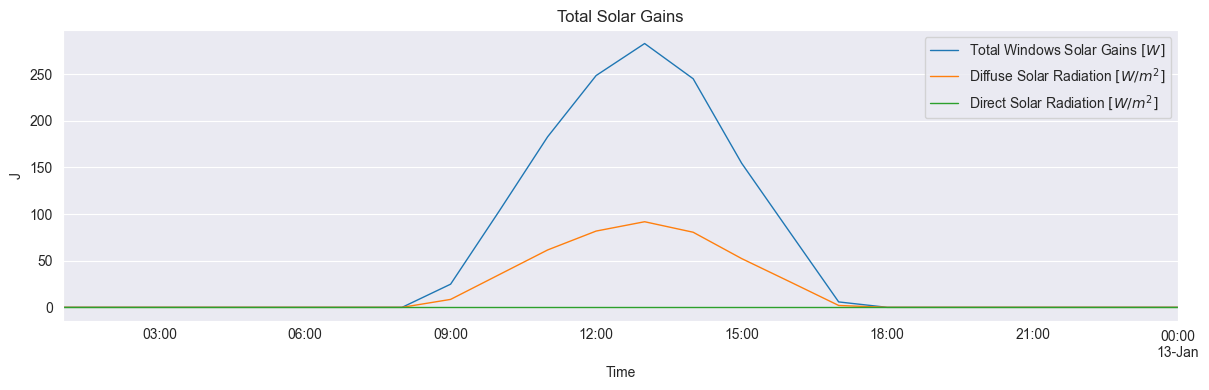

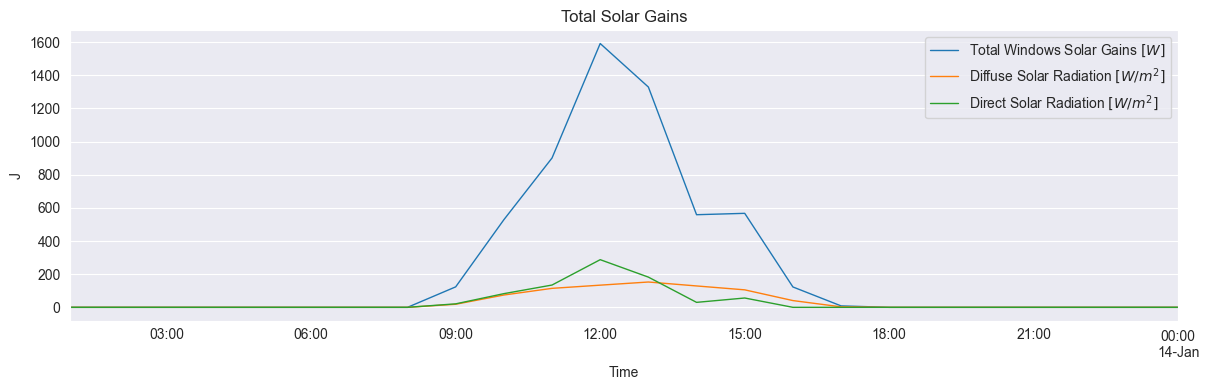

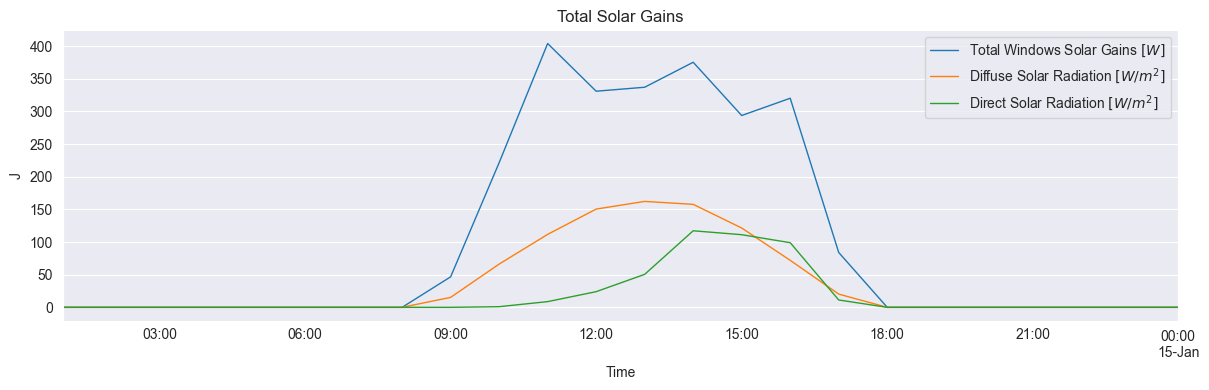

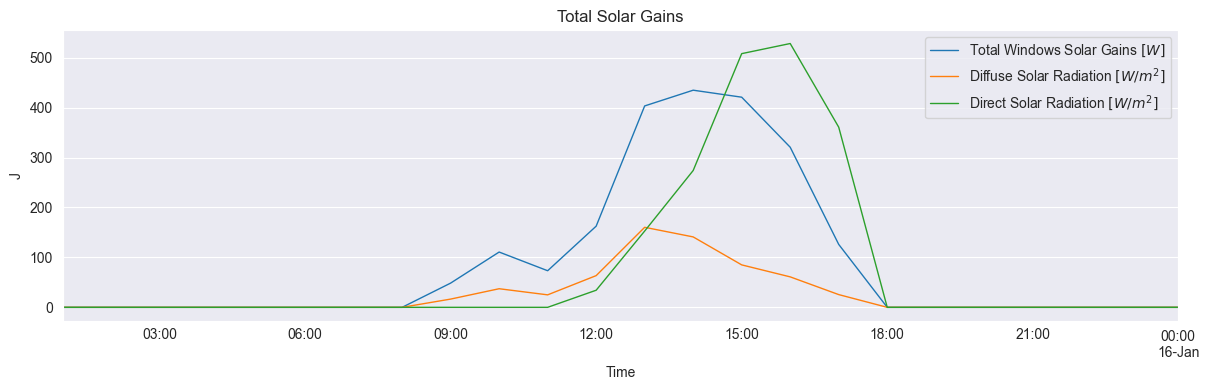

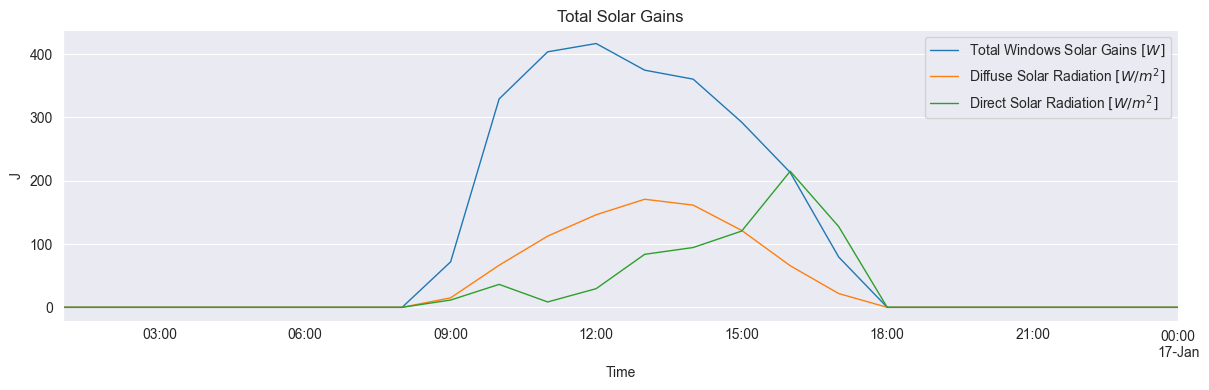

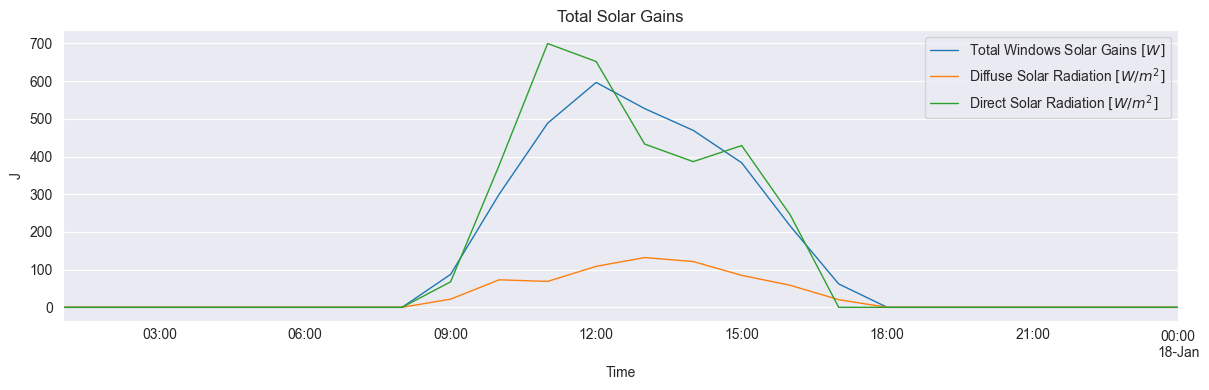

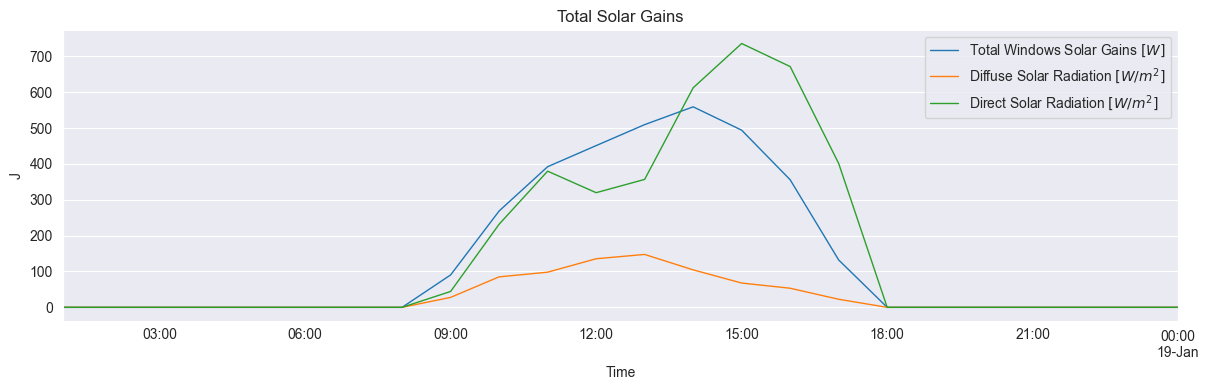

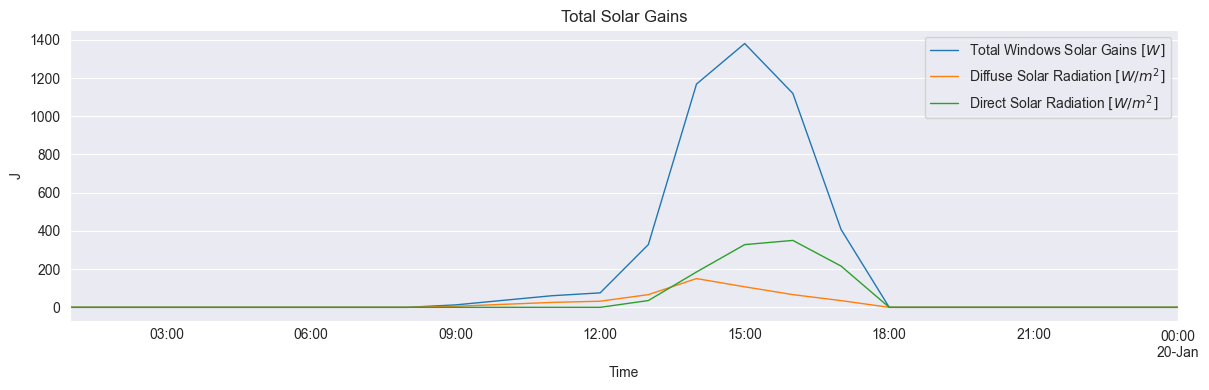

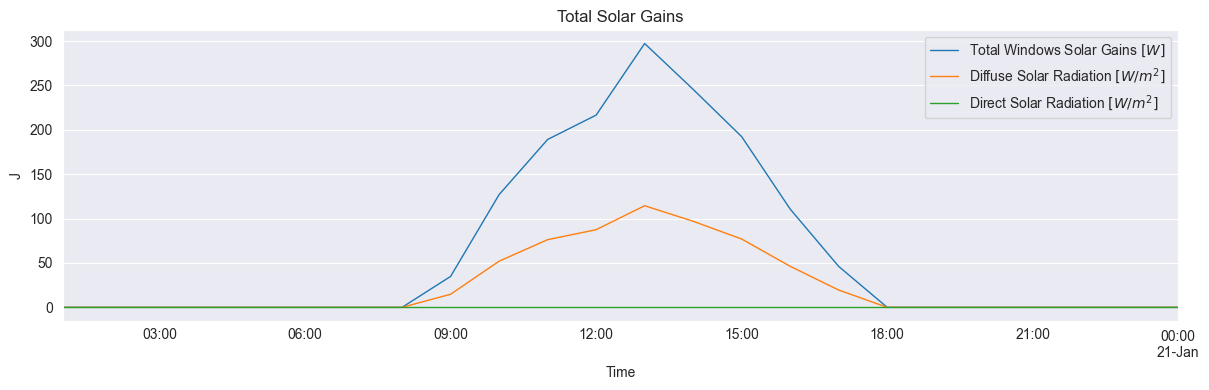

In [25]:
df_reho['Solar Gains'].plot(kind='line', lw=1, figsize=(12, 4))
plt.title('Total Solar Gains')
plt.tight_layout()
plt.xlabel('Time')
plt.ylabel('J')
plt.show()

# Plot zoomed in version day by day for the first 10 days using a for loop
for i in range(10, 20):
    df_reho['Solar Gains'].iloc[i*24:(i+1)*24].plot(kind='line', lw=1, figsize=(12, 4))
    df['Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly)'].iloc[i*24:(i+1)*24].plot(kind='line', lw=1, figsize=(12, 4))
    df['Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly)'].iloc[i*24:(i+1)*24].plot(kind='line', lw=1, figsize=(12, 4))
    plt.title('Total Solar Gains')
    plt.legend(['Total Windows Solar Gains $[W]$', 'Diffuse Solar Radiation $[W/m^2]$', 'Direct Solar Radiation $[W/m^2]$'])
    plt.tight_layout()
    plt.xlabel('Time')
    plt.ylabel('J')
    plt.show()


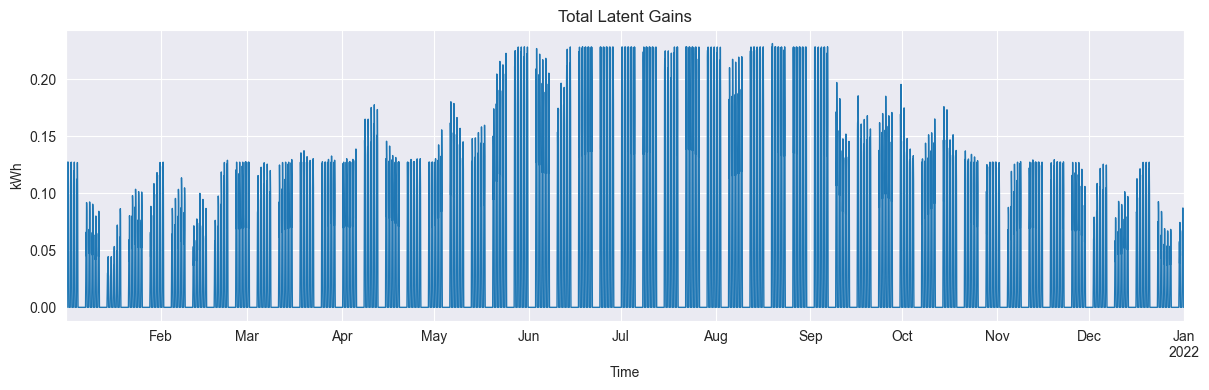

In [26]:
JtokWh = 3600000
df_reho['Latent Gains'].apply(lambda x: x/JtokWh).plot(kind='line', lw=1, figsize=(12, 4))
plt.title('Total Latent Gains')
plt.tight_layout()
plt.xlabel('Time')
plt.ylabel('kWh')
plt.show()

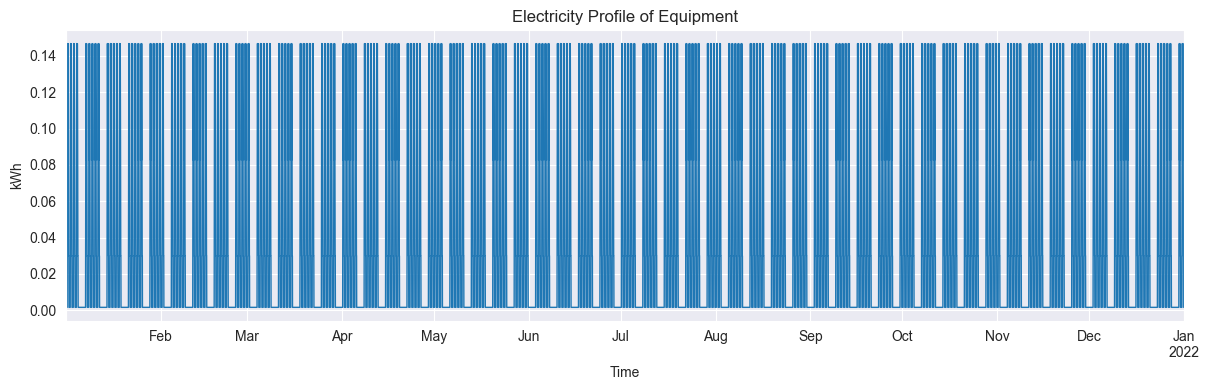

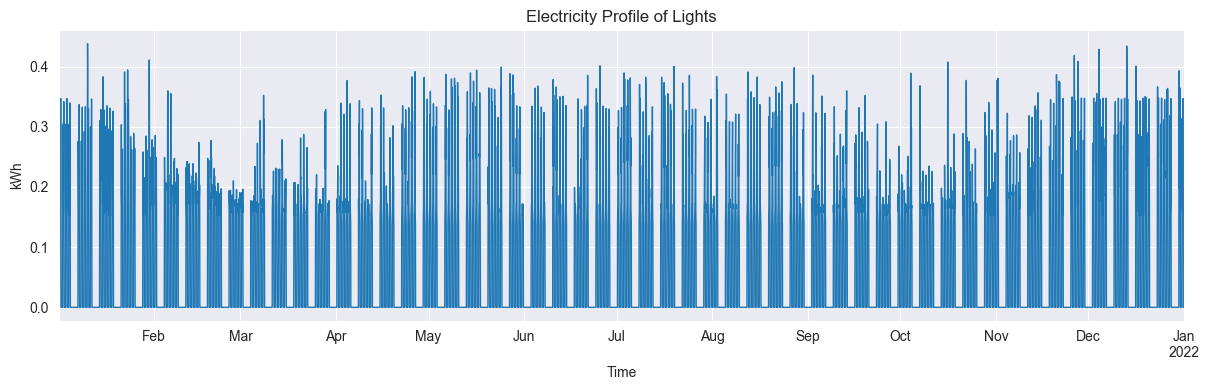

In [27]:
df_mtr = pd.read_csv(r".\output_data\idf1_mtr.csv", 
               parse_dates=[0],
               index_col=[0],
               date_parser=parse_energyplus_datetime_string 
              )

# Create filters
df_mtr['InteriorEquipment:Electricity [J](Hourly)'].apply(lambda x: x/JtokWh).plot(kind='line', lw=1, figsize=(12, 4))
plt.title('Electricity Profile of Equipment')
plt.tight_layout()
plt.xlabel('Time')
plt.ylabel('kWh')
plt.show()

df_mtr['InteriorLights:Electricity [J](Hourly)'].apply(lambda x: x/JtokWh).plot(kind='line', lw=1, figsize=(12, 4))
plt.title('Electricity Profile of Lights')
plt.tight_layout()
plt.xlabel('Time')
plt.ylabel('kWh')
plt.show()

In [28]:
print("\n Space heating MWh/yr: \n", reho_model.results["totex"][0]["df_Annuals"].xs("SH")[0:2]["Demand_MWh"])


 Space heating MWh/yr: 
 Hub
Building1                        0.878695
ElectricalHeater_SH_Building1         NaN
Name: Demand_MWh, dtype: float64


In [29]:
reho_model.results["totex"][0]["df_Annuals"]

,,Demand_MWh,Supply_MWh
Layer,Hub,,
Electricity,Network,19.248741,2.628987
NaturalGas,Network,0.000000,0.000000
Electricity,Building1,4.331000,NaN
Cooling,Building1,3.109044,NaN
DHW,Building1,0.091647,NaN
SH,Building1,0.878695,NaN
HeatGains,Building1,NaN,4.680000
SolarGains,Building1,NaN,4.680000
Electricity,Air_Conditioner_Air_Building1,0.710029,0.000000


In [30]:
reho_model.results['totex'][0]

{'df_Performance':               Costs_op   Costs_inv  ANN_factor  Costs_grid_connection  \
 Hub                                                                     
 Building1 -2481.171128  1580.49905    0.061157                    0.0   
 Network   -2481.171128  1580.49905    0.061157                    0.0   
 
            Costs_rep  Costs_ft      GWP_op  GWP_constr  EMOO_CAPEX  EMOO_OPEX  \
 Hub                                                                             
 Building1        0.0         0 -2160.56801  440.851972         NaN        NaN   
 Network          0.0         0 -2160.56801  440.851972         0.0        0.0   
 
            EMOO_TOTEX  EMOO_GWP  EMOO_grid   Objective  
 Hub                                                     
 Building1         NaN       NaN        NaN         NaN  
 Network           0.0       0.0        0.0 -900.673481  ,
 'df_Annuals':                                             Demand_MWh  Supply_MWh
 Layer       Hub                       